In [1]:
import numpy as np
import os, sys, torch, re
# from pytorch_lightning import LightningModule
# import src.utils as utils
from pathlib import Path
# /home/kan/ML_application/s4/outputs/2025-04-21/11-19-18/checkpoints/
torch.set_printoptions(
    threshold=float('inf'),      # すべての要素を表示
    precision=10,                # 小数点以下10桁まで表示
    linewidth=10**4              # 1行に表示する文字数（折り返し防止）
)
np.set_printoptions(
    threshold=float('inf'),      # すべての要素を表示
    precision=10,                # 小数点以下10桁まで表示
    linewidth=10**4              # 1行に表示する文字数（折り返し防止）
)
%matplotlib inline
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig_size_horizontal=20

def is_array(obj):
    return isinstance(obj, (list, np.ndarray))
def DESN_observer(
        u_ex, dim_rv, x_init=None, win=None, w=None, xinit_seed=0,winseed=0,wseed=0,
        rho=0.5,w_norm=True, sign=1, densin=0.1,density=0.5, activation="tanh", verbose=False):
    dim_u_ex = u_ex.shape[0] # Obtain the dimension of input and output
    Time_leng = u_ex.shape[1]

    if is_array(x_init)==False:
        np.random.seed(xinit_seed)
        x_init=np.random.uniform(-1.0, 1.0, dim_rv)
    if is_array(win)==False:
        np.random.seed(winseed)
        win = np.random.normal(
            loc=0, scale=1.0/dim_rv**0.5, size=(dim_rv, dim_u_ex), ) * (np.random.rand(dim_rv, dim_u_ex)<densin)
        # win = (2*np.random.rand(dim_rv,dim_u_ex)-1) * (np.random.rand(dim_rv, dim_u_ex)<densin)
    if is_array(w)==False:
        np.random.seed(wseed)
        w = (2*np.random.rand(dim_rv,dim_rv)-1) * (np.random.rand(dim_rv,dim_rv)<density)
    
    eig = np.linalg.eigvals(w)
    w = sign*w if dim_rv==1 or w_norm==False else rho*sign*w / np.max( np.abs(eig) )
    # print("w=",w, " eig=",eig)
    # print("win", win.shape, " vars", np.var(win.T[0]), np.var(win.T[1]))
    
    states_series = np.zeros((dim_rv, Time_leng))
    states_series[:,0]=x_init
    for t in range(1,Time_leng):
        if activation == "lin":
            states_series[:,t:t+1] = w @ states_series[:,t-1:t] + win @ u_ex[:, t-1:t]
        elif activation == "tanh":
            states_series[:,t:t+1] = np.tanh(w @ states_series[:,t-1:t] + (win @ u_ex[:, t-1:t]) )
        else:
            print("Error!!! No such activation function.")
            sys.exit()    
    return states_series

def rank_svd(A, thresh='No', rcond=1e-15,):
    dim_A = np.min(A.shape)

    if thresh=='N':
        finfo = np.finfo(A.dtype).eps #if finfo is None else finfo  # douBle=2^16
        u_, sigma_, v_ = np.linalg.svd(A, full_matrices=False)
        sigmax = sigma_.max()
        # print("rank_svd", A, sigma_, sigmax)
        rcond_=(sigmax) * dim_A * finfo
        index = np.where(sigma_ > rcond_)[0]
        rank=index.shape[0]
        rcond = rcond_/(sigmax)
    else:
        rank=np.linalg.matrix_rank(A)
    return rank, rcond

def MC_0ex_inv(
        N, X, Z, maxtau=51, Two=10**4, T=10**6,
        thresh='No', rcond=1e-15, debug=True):
    taus = np.arange(maxtau)# for MF
    MF = []
    # print("Z and X shapes", Z.shape, X.shape)
    X, Z = X[Two:], Z.reshape(-1, 1)
    Z2 = (Z[Two:].T @ Z[Two:]).reshape(-1)[0]
    # print("Z and X shapes", Z.shape, X.shape, " Z2!", Z2)
    B = X.T @ X
    B = B.astype(dtype=np.complex128)
    rank, rcond = rank_svd(B, thresh=thresh, rcond=rcond)
    B_1=np.linalg.pinv(B, rcond=rcond)
    rank_B1, _ = rank_svd(B_1, thresh=thresh)
    print("rankB1", rank_B1)
    for tau in taus[1:]:
        # print(Z[Two-tau:T+Two-tau].shape, X.shape)
        ZX = Z[Two-tau:T+Two-tau].T @ X
        ipc = ZX @ B_1 @ ZX.T /Z2
        ipc=ipc.reshape(-1)[0]
        if debug ==True:
            print(tau,ipc)#, (1-rho**2)*rho**(2*tau-2))
        MF.append(ipc)
    MF = np.array(MF, dtype=np.complex128)
    MC = np.sum(MF)
    if debug ==True:
        print("MC_0ex_inv:")
        print("rank: XX:=%d"%(rank))
        if T < 1000:
            rank_X_XX_X, rcond = rank_svd(X@B_1@X.T, thresh=thresh)
            print("rank: X_XX_X:=%d"%(rank_X_XX_X))
    return MC, MF, rank

def MC_3exNocor(
    N, lams, Two=int(1e4), maxtau=51, thresh='No', rcond=1e-15, debug=False
    ):
    # K=Two# Condition: K <= Two
    # delays = np.arange(0,K)# accuracy for MC
    taus = np.arange(1,maxtau) # for MF
    
    Cs_rho=0
    MF_rho=[]
    B=np.array([[1/(1-lams[i]*lams[j]) for i in range(N)] for j in range(N)])
    B=B.astype(dtype=np.complex128)
    rank, rcond = rank_svd(B, thresh=thresh, rcond=rcond)
    
    B_1=np.linalg.pinv(B, rcond=rcond)
    # print(B) # print(B_1) # print(B@B_1)
    for tau in taus:
        tauind=tau-1
        h=(lams**tauind).reshape((N,1))
        ipc=h.T @ B_1 @ h
        ipc=ipc.reshape(-1)[0]
        if debug:
            print(tauind,ipc)#, (1-rho**2)*rho**(2*tauind-2))
        Cs_rho+=ipc
        MF_rho.append(ipc)
    if debug:
        print(Cs_rho)
    
    return Cs_rho, np.array(MF_rho), rank

/root/.pyenv/versions/3.8.20/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# get paramas and MF

In [2]:
def get_params(filepath, dt, n_layer, index=20):
    ckpt = torch.load(filepath, map_location='cpu')
    # print(ckpt.keys())
    state_dict = ckpt['state_dict']
    # for key in state_dict.keys():
    #     print(key)
    lams_arr = []
    log_dt_arr = []
    wandb_arr = []
    for rep_layer in range(n_layer):
        # print("rep_layer", rep_layer)
        log_dt = state_dict["model.layers.%d.layer.kernel.kernel.log_dt"%rep_layer]
        log_w_real = state_dict["model.layers.%d.layer.kernel.kernel.log_w_real"%rep_layer]
        w_imag = state_dict["model.layers.%d.layer.kernel.kernel.w_imag"%rep_layer]
        w_imag = state_dict["model.layers.%d.layer.kernel.kernel.w_imag"%rep_layer]
        weight = state_dict["model.layers.%d.layer.output_linear.0.weight"%rep_layer].numpy()
        bias = state_dict["model.layers.%d.layer.output_linear.0.bias"%rep_layer].numpy()
        dts = torch.exp(log_dt) # (H)
        print("dts", dts.shape)
        # print(dts)
        mindt, maxdt, meandt=torch.min(dts), torch.max(dts), torch.mean(dts)
        # print("dts",mindt, maxdt, meandt)
        
        w_real = -torch.exp(log_w_real)
        # print("w_real", w_real.shape)
        # print("w_imag", w_imag.shape)
        w = w_real + 1j * w_imag
        print("w",w.shape)
        
        w=w[index,...]
        dtA = (w * torch.exp(dt))
        A = torch.exp(dtA) # (H N)
        # print("A", A.shape, A)
        rho = torch.max(torch.abs(A))
        # print("rho", rho)
        
        bias_reshaped = bias.reshape(-1, 1, 1)
        wandb = np.concatenate([bias_reshaped, weight], axis=1)[:, :,0]
        print("wandb", wandb.shape, " weight", weight.shape, " bias", bias.shape)
        
        log_dt_arr.append(log_dt.numpy()), lams_arr.append(A.numpy()), wandb_arr.append(wandb)
        # w *= rho/np.max(np.abs(lams))
        # dtA = w * dts.unsqueeze(-1)  # (H N)
        # A = torch.exp(dtA) # (H N)
    return log_dt_arr, lams_arr, wandb_arr

base_dir = "/home/kan/ML_application/s4/outputs/"
# max_depth = 2
# base_dir_ = Path(base_dir)

dt = torch.tensor([0, -5, -9][2])
n_layer = 6
data_dict={}

# for file in base_dir_.glob("*/*/checkpoints/*"):
#     if file.is_file():
#         parent_path = file.parents[1]
#         print("parent_path",parent_path)
#         print("file",file)

files = ["2025-05-13/18-29-34/"]
# files = ["2025-05-14/12-55-47/"]
# /home/kan/ML_application/s4/outputs/2025-05-14/12-55-47/checkpoints/
for file in files:
    dirpath = base_dir+file+"checkpoints/"
    file_paths = []
    for root, dirs, files in os.walk(dirpath):
        for file in files:
            if file.endswith('.ckpt'):
                file_paths.append(os.path.join(root, file))
    
    for filepath in file_paths:
        print(filepath)
        filepath_split = filepath.split("/")
        print(filepath_split[-1])
        log_dt_arr, lams_arr, wandb = get_params(filepath, dt=dt, n_layer=n_layer)
        print("")
        key_split = re.split(r"[-=]", filepath_split[-1])
        print(key_split)
        if not ("last.ckpt" in key_split):
            key = key_split[1]
        key = "999" if "last.ckpt" in key_split else key
        data_dict[int(key)] = [np.array(log_dt_arr), np.array(lams_arr), wandb]
    
    break


/home/kan/ML_application/s4/outputs/2025-05-13/18-29-34/checkpoints/epoch=00-metric=0.5153.ckpt
epoch=00-metric=0.5153.ckpt
dts torch.Size([256])
w torch.Size([256, 32])
wandb (512, 257)  weight (512, 256, 1)  bias (512,)
dts torch.Size([256])
w torch.Size([256, 32])
wandb (512, 257)  weight (512, 256, 1)  bias (512,)
dts torch.Size([256])
w torch.Size([256, 32])
wandb (512, 257)  weight (512, 256, 1)  bias (512,)
dts torch.Size([256])
w torch.Size([256, 32])
wandb (512, 257)  weight (512, 256, 1)  bias (512,)
dts torch.Size([256])
w torch.Size([256, 32])
wandb (512, 257)  weight (512, 256, 1)  bias (512,)
dts torch.Size([256])
w torch.Size([256, 32])
wandb (512, 257)  weight (512, 256, 1)  bias (512,)

['epoch', '00', 'metric', '0.5153.ckpt']
/home/kan/ML_application/s4/outputs/2025-05-13/18-29-34/checkpoints/last.ckpt
last.ckpt
dts torch.Size([256])
w torch.Size([256, 32])
wandb (512, 257)  weight (512, 256, 1)  bias (512,)
dts torch.Size([256])
w torch.Size([256, 32])
wandb (512, 25

(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)
(512, 257)


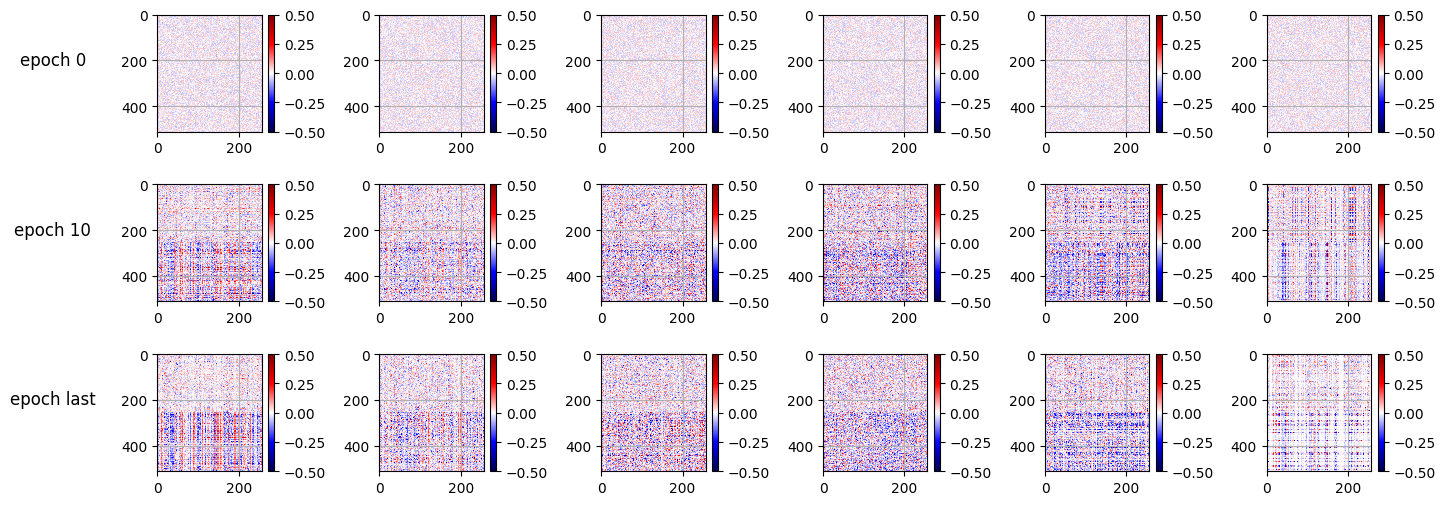

In [3]:
data_dict = dict(sorted(data_dict.items()))
# for rep, (key, val) in enumerate(data_dict.items()):
#     print(key)
plot_epochs = [0,10,999]#[0, 10, 20, 30, 999]

nrows, ncols = len(plot_epochs), 6
axis_wide, axis_high = 8.0, 6.0
fig_ratio = 0.8
wspace, hspace = 0.7, 0.45
fig_wide = ncols*(axis_wide+wspace)
fig_high = nrows*(axis_high+hspace)
fig_wide_size = fig_size_horizontal*fig_ratio
fig_high_size = fig_size_horizontal*fig_ratio*fig_high/fig_wide
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                    figsize = (fig_wide_size, fig_high_size)
                    )#, subplot_kw=dict(projection="polar"))
fig.subplots_adjust(wspace=wspace, hspace=hspace)
# fig.suptitle("log dt = %d"%dt, x=0.5, y=0.93, fontsize=20)
# plt.figure(figsize=(10, 6))
fig_rep=0
for rep, (key, val) in enumerate(data_dict.items()):
    title = "epoch last" if key==999 else "epoch %d"%key
    if not key in plot_epochs:
        continue
    
    plot_mats = np.array(val[2])
    # print(key, plot_mats.shape)
    for rep_layer in range(n_layer):
        axid = ax[fig_rep][rep_layer]
        axid.set_title(title, x= -1.0, y=0.5, )
        title=""
        plot_mat=plot_mats[rep_layer]
        print(plot_mat.shape)
        bar1 = axid.imshow(
            plot_mat,
            # extent=limits, 
            interpolation='nearest', cmap='seismic', aspect='auto',# norm=matplotlib.colors.LogNorm()
            vmin=-0.5,vmax=0.5,
            )
        # axid.set_title(plot_mats_names[rep], )#x= -0.5, y=0.5, )
        # axid.set_xlabel(r'$\tau$')
        # axid.set_yticks([0, 0.5, 1.0])
        plt.colorbar(bar1, ax=axid)
        axid.grid()
        # axid.set_xlabel('indices')
        # axid.set_ylabel('log dt')
        # axid.set_ylim(-10, -4)
    fig_rep+=1
plt.savefig('S4dinv_params_readout.svg', format='svg')

0 (6, 32)
lams 0 [0.98742175+1.5771520e-01j 0.9986322 +5.1095016e-02j 0.9994985 +2.9660705e-02j 0.99972904+2.0468723e-02j 0.99981916+1.5361080e-02j 0.99986464+1.2111754e-02j 0.99988985+9.8632881e-03j 0.999905  +8.2114981e-03j 0.99991393+6.9500217e-03j 0.9999206 +5.9532407e-03j 0.9999249 +5.1465211e-03j 0.99992824+4.4819331e-03j 0.9999306 +3.9223768e-03j 0.99993247+3.4449308e-03j 0.99993366+3.0341637e-03j 0.99993426+2.6759850e-03j 0.9999353 +2.3620927e-03j 0.9999357 +2.0830093e-03j 0.9999363 +1.8331434e-03j 0.9999368 +1.6119059e-03j 0.99993736+1.4097820e-03j 0.99993706+1.2285812e-03j 0.999937  +1.0604663e-03j 0.9999377 +9.0918789e-04j 0.9999383 +7.7007472e-04j 0.9999379 +6.4178102e-04j 0.9999381 +5.2071689e-04j 0.9999377 +4.1157985e-04j 0.99993783+3.1053514e-04j 0.99993837+2.1263753e-04j 0.9999383 +1.2329205e-04j 0.99993825+3.9623177e-05j]
rankB1 8
lams 1 [0.98742265+1.5771623e-01j 0.9986317 +5.1096126e-02j 0.9994987 +2.9659145e-02j 0.99972826+2.0469151e-02j 0.9998203 +1.5362150e-02j 0.

/tmp/ipykernel_2592815/1497077318.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  states_series[:,t:t+1] = w @ states_series[:,t-1:t] + win @ u_ex[:, t-1:t]
/root/.pyenv/versions/3.8.20/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


rankB1 8
lams 2 [0.9874219 +1.5771623e-01j 0.99863213+5.1093716e-02j 0.9994983 +2.9660018e-02j 0.99972886+2.0469276e-02j 0.99981993+1.5362132e-02j 0.99986464+1.2112578e-02j 0.9998898 +9.8617263e-03j 0.99990463+8.2121566e-03j 0.9999141 +6.9496930e-03j 0.999921  +5.9528742e-03j 0.9999243 +5.1482487e-03j 0.9999284 +4.4815079e-03j 0.9999301 +3.9220499e-03j 0.9999324 +3.4444628e-03j 0.99993354+3.0337030e-03j 0.99993426+2.6760371e-03j 0.99993557+2.3610324e-03j 0.99993604+2.0824622e-03j 0.9999374 +1.8350327e-03j 0.9999365 +1.6114268e-03j 0.9999371 +1.4098991e-03j 0.99993736+1.2270826e-03j 0.9999375 +1.0623778e-03j 0.99993783+9.0882904e-04j 0.99993724+7.6905172e-04j 0.99993783+6.4115331e-04j 0.9999384 +5.2083720e-04j 0.99993855+4.1115304e-04j 0.9999383 +3.0866801e-04j 0.9999387 +2.1224782e-04j 0.99993795+1.2263452e-04j 0.9999383 +4.0825060e-05j]
rankB1 8
lams 3 [0.9874216 +1.5771680e-01j 0.99863166+5.1096208e-02j 0.9994983 +2.9659541e-02j 0.99972916+2.0468542e-02j 0.9998201 +1.5363705e-02j 0.9

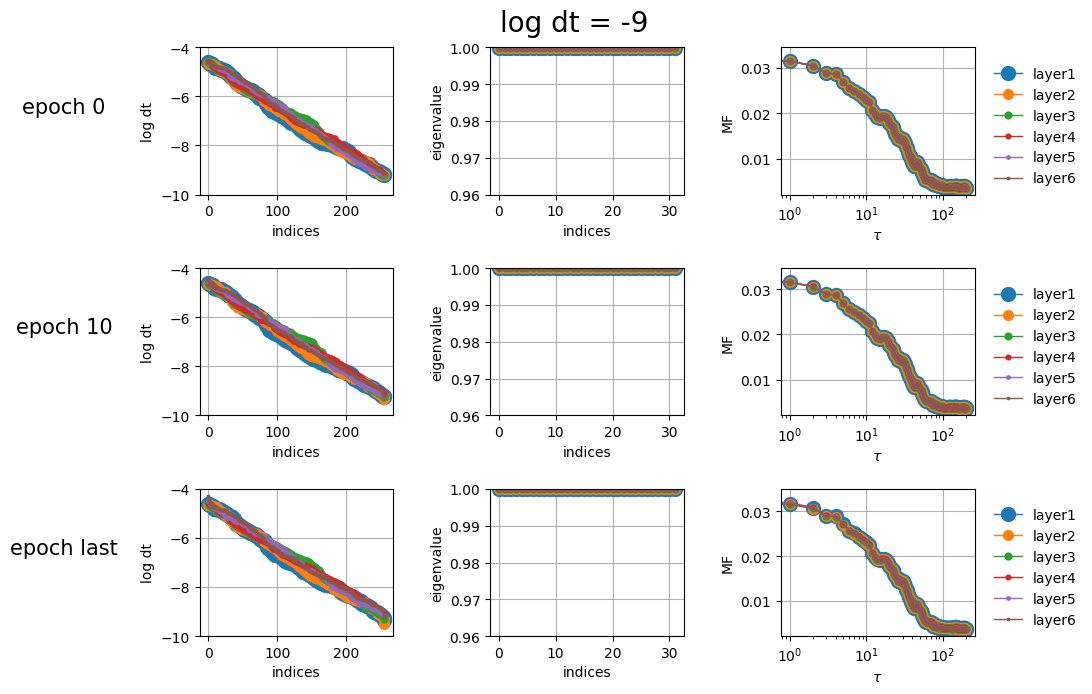

In [6]:
inputname = ["gauss", "uniform"][1]
shuff = [True, False][1]
ex_input_scale1 = [0, 0.05, 0.1, 0.2, 0.5, 1][2]
densin_shared = [True, False][0]
activation = ['lin', 'tanh'][0]
plot_epochs = [0, 10, 999] #[0, 10, 20, 30, 999]

nrows, ncols = len(plot_epochs), 3
axis_wide, axis_high = 8.0, 6.0
fig_ratio = 0.5
wspace, hspace = 0.5, 0.5
fig_wide = ncols*(axis_wide+wspace)
fig_high = nrows*(axis_high+hspace)
fig_wide_size = fig_size_horizontal*fig_ratio
fig_high_size = fig_size_horizontal*fig_ratio*fig_high/fig_wide
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                    figsize = (fig_wide_size, fig_high_size)
                    )#, subplot_kw=dict(projection="polar"))
fig.subplots_adjust(wspace=wspace, hspace=hspace)
fig.suptitle("log dt = %d"%dt, x=0.5, y=0.93, fontsize=20)
# plt.figure(figsize=(10, 6))
fig_rep=0
ms0 = 20
for rep, (key, val) in enumerate(data_dict.items()):
    title = "epoch last" if key==999 else "epoch %d"%key
    if not key in plot_epochs:
        continue
    
    # for dt in dts:
    #     print(dt)
    dts_arr = val[0]
    lams_arr = val[1]
    print(key, lams_arr.shape)
    axid = ax[fig_rep][0]
    axid.set_title(title, x= -0.7, y=0.5, fontsize=15)
    for rep_layer in range(n_layer):
        dts = dts_arr[rep_layer]
        dts = dts[np.argsort(np.abs(dts))]
        axid.plot(
            dts,
            # label="num", #+ noisename,
            # lw=10*0.7**rep_layer,
            lw=1, ms=ms0*0.7**rep_layer,
            marker='.', 
            )
    axid.grid()
    axid.set_xlabel('indices')
    axid.set_ylabel('log dt')
    axid.set_ylim(-10, -4)
    
    axid = ax[fig_rep][1]
    axid.set_xlabel('indices')
    # axid.set_yticks([0, 0.5, 1.0])
    axid.set_ylabel('eigenvalue')
    axid.grid()
    for rep_layer in range(n_layer):
        lams = np.abs(lams_arr[rep_layer])
        lams = lams[np.argsort(np.abs(lams))]
        
        # print(lams)
        axid.plot(
            lams,
            # label="num", #+ noisename,
            lw=1, ms=ms0*0.7**rep_layer,
            marker='.', 
            )
    axid.set_ylim(0.96, 1.0)
    
    axid = ax[fig_rep][2]
    fig_rep+=1
    axid.set_xlabel(r'$\tau$')
    # axid.set_ylim(-10**3, 10**3)
    # axid.set_ylim(-0, 1.1)
    # axid.set_yticks([0, 0.5, 1.0])
    axid.set_ylabel('MF')
    axid.grid()
    axid.set_xscale('log')
    # ax.set_yscale('log')
    for rep_layer in range(n_layer):
        lams = lams_arr[rep_layer]
        print("lams",rep_layer, lams)
        dim_rv = lams.shape[0]
        # print(dim_rv, lams.shape)
        # mc, mf, rank =MC_3exNocor(dim_rv, lams.numpy(), Two=int(1e4), maxtau=51, debug=False)
        #################################
        Two, T = 5*10**2, 10**4
        np.random.seed(2)
        vsigma=1
        u = 2*np.random.rand(Two+T)-1
        u *= ex_input_scale1/np.std(u)
        u_ex = np.array([u])
        # np.random.seed(seedin+1)
        # win = (2*np.random.rand(dim_rv,2)-1) * (np.random.rand(dim_rv,2)<densin)
        # win = np.random.normal(dim_rv,2) * (np.random.rand(dim_rv, 2)<densin)
        # np.random.seed(w_index+3)
        if densin_shared:
            w1 = (2*np.random.rand(dim_rv)-1) * (np.random.rand(dim_rv)<1.0)
            win = np.array([w1]).T
        
        maxtau=200
        states_series=DESN_observer(
            u_ex, dim_rv,
            x_init=np.zeros(dim_rv), w = np.diag(lams), win = win,
            rho=1.0, w_norm=True,# False if lam_name=="gauss" else True,
            densin = 1.0, density = None,
            activation = activation,)
        rcond=1e-15
        # print(np.var(u), np.var(v))
        MC_num, MFs_num, ranks_num = MC_0ex_inv(
            dim_rv, states_series.T, u, maxtau=maxtau, Two=Two, T=T, thresh='N', rcond=rcond,
            debug=False,
            )
        axid.plot(
            MFs_num,
            label="layer%d"%(rep_layer+1), #+ noisename,
            lw=1, ms=ms0*0.7**rep_layer,
            marker='.', 
            )
        axid.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1, frameon=False)
plt.savefig("S4dinv_params_kernel_%d.svg"%dt, format='svg')

# Experiments that do not work

In [5]:
import torch, wandb
import numpy as np
np.set_printoptions(threshold=np.inf, precision=10, linewidth=10**4)
torch.set_printoptions(threshold=np.inf, precision=10, linewidth=10**4)
api = wandb.Api()
print(api)

project_name = 'hippo'
run_id = wandb.run.id  # 現在のランIDを取得
print(run_id)

runs = api.runs(project_name)
print(runs)

for idx, run in enumerate(runs):
    print(idx, run.id)
    print(run)
    metrics = run.history()
    # for rep, met in enumerate(metrics):
    #     print(met)
    
    artifacts = run.logged_artifacts()  # ランに関連する全てのアーティファクト
    for artifact in artifacts:
        print(artifact)
        if 'model' in artifact.name.lower():  # モデルアーティファクトを特定する
            print(f"Artifact Name: {artifact.name}")
            print(f"Artifact Type: {artifact.type}")
            print(f"Artifact Metadata: {artifact.metadata}")  # メタデータにモデルに関する情報が含まれていることがあります
    if idx==2:
        break

# run = api.run("ユーザー名/プロジェクト名/ランID")
# artifact = run.use_artifact("モデル名:latest") #（例：last.ckpt）
# artifact_dir = artifact.download()

# model = MyModel.load_from_checkpoint(artifact_dir + "/last.ckpt") # モデル読み込み（Lightningなど使ってるなら）

AttributeError: 'NoneType' object has no attribute 'id'

In [ ]:
# @hydra.main(config_path="./configs/model/", config_name="s4d", version_base=None)
# def get_model(model_config: DictConfig):
#     print(model_config)  # DictConfigとしてアクセス可能
#     for key in model_config.keys():
#         print(key, model_config[key])
#     model = utils.instantiate(registry.model, model_config)#.load_from_checkpoint("path/to/model.ckpt")
#     print(model)
    
#     state_dict = model.state_dict()
#     for k, v in state_dict.items():
#         print(k, v.shape)

# import sys
# sys.path.append('/home/kan/ML_application/s4/src')
# layer_key = ["s4d", ][0]
# print(registry.model["model"])
# print(registry.layer[layer_key])
# print(registry.model["model"](layer=registry.layer[layer_key]))
# ckpt ファイルをロード
# model = utils.instantiate(registry.model, layer="s4d", )
# registry.model["model"](layer=layer).load_from_checkpoint("path/to/model.ckpt")

# for root, dirs, files in os.walk(base_dir):
#     # 今の階層の深さを数える
#     depth = root[len(base_dir):].count(os.sep)
#     print(depth)
#     if depth > max_depth:
#         # さらに深い階層の探索をやめる
#         dirs[:] = []
#         continue

#     for file in files:
#         print(os.path.join(root, file))

In [ ]:
from pytorch_lightning import LightningModule
# import src.utils as utils
from pathlib import Path

import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf
# from hydra.utils import instantiate

from src.utils import registry, instantiate

def check_model(model_name="model", cfg_name="config", cfg_path="./configs/model/",  model_path="", ):
    with initialize(config_path=cfg_path):
        cfg = compose(config_name=cfg_name)
    print("cfg", cfg)
    OmegaConf.set_struct(cfg, False)
    # cfg.model._target_ = "torch.nn.Identity" 
    ModelClass = hydra.utils.get_class(registry.model[model_name])
    # model = ModelClass(cfg)
    
    # model = instantiate(cfg.model) # registry.model,
    model = instantiate(registry.model, cfg) # モデル構造のインスタンス化（この時点でランダム初期化）
    print(model)
    print("type", type(model))
    ckpt = torch.load(model_path, map_location="cpu")# チェックポイントからstate_dictを読み込み
    # state_dict = {k.replace("model.", ""): v for k, v in ckpt["state_dict"].items()}
    # model.load_state_dict(state_dict)
    print("Checkpoint keys:", ckpt.keys())  # 追加
    
    state_dict = ckpt.get("state_dict", ckpt)
    model.load_state_dict(state_dict)
    # if "state_dict" in ckpt:
    #     state_dict = ckpt["state_dict"]
    # else:
    #     state_dict = ckpt
    # model.load_state_dict(state_dict)
    
    # for key in cfg.keys():
    #     print(key, cfg[key])
    # model = utils.instantiate(registry.model, cfg).load_from_checkpoint(model_path)

    print(model)
    
# /home/kan/ML_application/s4/outputs/2025-04-21/11-19-18/checkpoints/

base_dir = "/home/kan/ML_application/s4/outputs/"
max_depth = 2

base_dir_ = Path(base_dir)
for file in base_dir_.glob("*/*/checkpoints/*"):
    if file.is_file():
        parent_path = file.parents[1]
        print(parent_path)
        print(file)
        relative_path = parent_path.parts[parent_path.parts.index("outputs"):]  # s4 以降の部分を抽出
        cfg_path = "/".join(relative_path)+ "/.hydra"
        print(cfg_path)
        check_model(model_name="model", cfg_path=cfg_path, model_path=file)


/home/kan/ML_application/s4/outputs/2025-04-20/22-59-56
/home/kan/ML_application/s4/outputs/2025-04-20/22-59-56/checkpoints/last.ckpt
outputs/2025-04-20/22-59-56/.hydra
cfg {'train': {'seed': 0, 'interval': 'epoch', 'monitor': 'val/accuracy', 'mode': 'max', 'ema': 0.0, 'test': False, 'debug': False, 'ignore_warnings': False, 'state': {'mode': None, 'chunk_len': None, 'overlap_len': None, 'n_context': 0, 'n_context_eval': '${.n_context}'}, 'sweep': None, 'group': None, 'benchmark_step': False, 'benchmark_step_k': 1, 'benchmark_step_T': 1, 'checkpoint_path': None, 'visualizer': 'filters', 'disable_dataset': False}, 'wandb': {'project': 'hippo', 'group': '', 'job_type': 'training', 'mode': 'online', 'save_dir': None, 'id': None}, 'trainer': {'accelerator': 'cuda', 'devices': [0, 1, 2, 3, 4, 5, 6, 7], 'accumulate_grad_batches': 1, 'max_epochs': 100, 'gradient_clip_val': 0.0, 'log_every_n_steps': 10, 'limit_train_batches': 1.0, 'limit_val_batches': 1.0, 'enable_progress_bar': True}, 'loader

/tmp/ipykernel_649803/159137829.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path=cfg_path):


InstantiationException: Cannot instantiate config of type type.
Top level config must be an OmegaConf DictConfig/ListConfig object,
a plain dict/list, or a Structured Config class or instance.